In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Wasserstein (WGAN) – Génération de visages avec GPU

Ce notebook montre comment entraîner un **Wasserstein GAN** pour générer des visages artificiels.

- Utilise PyTorch
- Fonctionne sur GPU (Colab)
- Dataset : FakeFaces (simulé avec CIFAR10 ou FashionMNIST ici pour légèreté)
- Inclut mesure du **temps d'entraînement**


Importer les librairies nécessaires:

In [ ]:
# ✅ Setup: imports + check GPU
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ GPU activé :", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU uniquement")

✅ GPU activé : Tesla T4


# CelebA

Télécharger et préparer le dataset CelebA

2. Décompresser l’archive dans un dossier local




In [ ]:
import zipfile
import os

zip_path = '/content/drive/MyDrive/WGAN_Celeberity/img_align_celeba.zip'
extract_to = '/content/data/img_align_celeba'

# Crée le dossier si besoin
os.makedirs(extract_to, exist_ok=True)

# Extraction
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print("Extraction terminée.")


Extraction terminée.


3. Préparer le dataset pour PyTorch

 4. Vérification rapide

In [ ]:
import os
import shutil

# Define the source and destination directories
source_dir = '/content/data/img_align_celeba/img_align_celeba'
dest_dir = '/content/data/img_align_celeba/img_align_celeba/data'

# Create the destination directory if it doesn't exist
os.makedirs(dest_dir, exist_ok=True)

# Move all .jpg files to the destination directory
for filename in os.listdir(source_dir):
    if filename.endswith('.jpg'):
        shutil.move(os.path.join(source_dir, filename), dest_dir)

print("Images moved to 'data' subfolder.")

Images moved to 'data' subfolder.


In [ ]:
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# Transformation
transform = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)  # [-1, 1]
])

# Utilise ImageFolder si tu n'as pas les fichiers de partition
dataset = ImageFolder(root='/content/data/', transform=transform)

# Ou spécifie le chemin vers les images directement si tu veux bypasser les classes
# en créant une classe custom (dispo sur demande)

dataloader = DataLoader(dataset, batch_size=128, shuffle=True, num_workers=2)


In [ ]:
#dataset = ImageFolder(root='/content/data/img_align_celeba/img_align_celeba', transform=transform)

In [ ]:
# dataloader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=2)

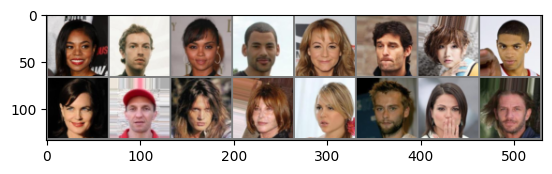

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Voir un batch
dataiter = iter(dataloader)
images, _ = next(dataiter)

# Inverser la normalisation
def imshow(img):
    img = img / 2 + 0.5  # dé-normalise
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

imshow(torchvision.utils.make_grid(images[:16]))

1. Ce qu’on veut faire avec un WGAN
Un WGAN améliore le GAN classique en :

- Utilisant la distance de Wasserstein au lieu de la divergence de Jensen-Shannon

- Remplaçant le discriminateur par un critiquer (Critic)

  - Pas de sigmoid, pas de log — juste des scores réels

  - Ajout d’un clipping des poids dans le critic (ou une pénalité de gradient avec WGAN-GP)

## Étape 1 – Définir le générateur et le discriminateur (critic)

In [ ]:
import torch
import torch.nn as nn

# Paramètres
nz = 100       # taille du bruit latent
ngf = 64       # feature map générateur
ndf = 64       # feature map discriminateur
nc = 3         # nombre de canaux (RGB)

# Générateur
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

# Critic (Discriminateur sans sigmoid)
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False)
        )

    def forward(self, input):
        return self.main(input).view(-1)


##Étape 2 – Initialisation et setup du WGAN

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

netG = Generator().to(device)
netD = Discriminator().to(device)

# Initialisation des poids
def weights_init(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
        nn.init.normal_(m.weight.data, 0.0, 0.02)

netG.apply(weights_init)
netD.apply(weights_init)

# Optimizers (sans beta1 pour WGAN)
lr = 5e-5
optimizerD = torch.optim.RMSprop(netD.parameters(), lr=lr)
optimizerG = torch.optim.RMSprop(netG.parameters(), lr=lr)


##Étape 3 – Boucle d’entraînement (WGAN classique)

In [ ]:
import torch
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import os

# Reconfig si besoin
num_epochs = 10
n_critic = 5
clip_value = 0.01
batch_size = 64
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Créer le dossier pour sauvegarder les images
os.makedirs("images", exist_ok=True)

# Pour suivi des metrics
G_losses = []
D_losses = []

print("📢 Début de l'entraînement WGAN...")

for epoch in range(num_epochs):
    for i, (real_images, _) in enumerate(dataloader):
        ############################
        # (1) Mise à jour du Critic
        ############################
        for _ in range(n_critic):
            netD.zero_grad()
            real_images = real_images.to(device)

            # Real loss
            D_real = netD(real_images)
            loss_real = -torch.mean(D_real)

            # Fake loss
            noise = torch.randn(real_images.size(0), nz, 1, 1, device=device)
            fake_images = netG(noise).detach()
            D_fake = netD(fake_images)
            loss_fake = torch.mean(D_fake)

            # Total loss & backward
            D_loss = loss_real + loss_fake
            D_loss.backward()
            optimizerD.step()

            # Clipping weights
            for p in netD.parameters():
                p.data.clamp_(-clip_value, clip_value)

        ############################
        # (2) Mise à jour du Générateur
        ############################
        netG.zero_grad()
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake_images = netG(noise)
        G_loss = -torch.mean(netD(fake_images))
        G_loss.backward()
        optimizerG.step()

        # Suivi des pertes
        G_losses.append(G_loss.item())
        D_losses.append(D_loss.item())

        # Affichage progressif
        if i % 100 == 0:
            print(f"[{epoch}/{num_epochs}][{i}/{len(dataloader)}] "
                  f"D_loss: {D_loss.item():.4f} G_loss: {G_loss.item():.4f}")

    # Sauvegarde d'images à chaque epoch
    with torch.no_grad():
        fake = netG(fixed_noise).detach().cpu()
        vutils.save_image(fake, f"images/fake_samples_epoch_{epoch:03d}.png", normalize=True)


📢 Début de l'entraînement WGAN...
[0/10][0/3166] D_loss: -0.0764 G_loss: 0.0025
[0/10][100/3166] D_loss: -1.4881 G_loss: 0.7042
[0/10][200/3166] D_loss: -1.5070 G_loss: 0.7085
[0/10][300/3166] D_loss: -1.5100 G_loss: 0.7092
[0/10][400/3166] D_loss: -1.5102 G_loss: 0.7096
[0/10][500/3166] D_loss: -1.5091 G_loss: 0.7098
[0/10][600/3166] D_loss: -1.5125 G_loss: 0.7097
[0/10][700/3166] D_loss: -1.5110 G_loss: 0.7092
[0/10][800/3166] D_loss: -1.5095 G_loss: 0.7084
[0/10][900/3166] D_loss: -1.5092 G_loss: 0.7080
[0/10][1000/3166] D_loss: -1.5104 G_loss: 0.7085
[0/10][1100/3166] D_loss: -1.5110 G_loss: 0.7085
[0/10][1200/3166] D_loss: -1.5097 G_loss: 0.7083
[0/10][1300/3166] D_loss: -1.5101 G_loss: 0.7081
[0/10][1400/3166] D_loss: -1.5091 G_loss: 0.7081
[0/10][1500/3166] D_loss: -1.5047 G_loss: 0.7036
[0/10][1600/3166] D_loss: -1.5073 G_loss: 0.7070
[0/10][1700/3166] D_loss: -1.4958 G_loss: 0.7037
[0/10][1800/3166] D_loss: -1.5001 G_loss: 0.7047
[0/10][1900/3166] D_loss: -1.5001 G_loss: 0.704

## WGAN-GP – avec sauvegarde de modèle .pkl et courbes d'apprentissage

* WGAN-GP remplace le clipping des poids par une pénalité de gradient. Cela améliore fortement la stabilité de l'entraînement.

**Étape 1 – Fonction de pénalité de gradient**

In [ ]:
def gradient_penalty(critic, real, fake, device="cuda"):
    batch_size, c, h, w = real.shape
    alpha = torch.rand(batch_size, 1, 1, 1).to(device)
    interpolated = alpha * real + (1 - alpha) * fake
    interpolated.requires_grad_(True)

    critic_output = critic(interpolated)
    gradients = torch.autograd.grad(
        outputs=critic_output,
        inputs=interpolated,
        grad_outputs=torch.ones_like(critic_output),
        create_graph=True,
        retain_graph=True,
    )[0]

    gradients = gradients.view(gradients.size(0), -1)
    gradient_norm = gradients.norm(2, dim=1)
    gp = ((gradient_norm - 1) ** 2).mean()
    return gp


**Étape 2 – Boucle d'entraînement avec GP et sauvegarde**

In [ ]:
import pickle
import torch
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import os

lambda_gp = 10
G_losses = []
D_losses = []
num_epochs = 5
n_critic = 2
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Créer dossier de sauvegarde
import os
os.makedirs("images", exist_ok=True)

for epoch in range(num_epochs):
    for i, (real_images, _) in enumerate(dataloader):
        real_images = real_images.to(device)
        batch_size = real_images.size(0)

        ########################
        # 1. Train Critic
        ########################
        for _ in range(n_critic):
            netD.zero_grad()
            noise = torch.randn(batch_size, nz, 1, 1, device=device)
            fake_images = netG(noise).detach()

            D_real = netD(real_images)
            D_fake = netD(fake_images)

            gp = gradient_penalty(netD, real_images, fake_images, device)
            D_loss = -torch.mean(D_real) + torch.mean(D_fake) + lambda_gp * gp

            D_loss.backward()
            optimizerD.step()

        ########################
        # 2. Train Generator
        ########################
        netG.zero_grad()
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake_images = netG(noise)
        G_loss = -torch.mean(netD(fake_images))
        G_loss.backward()
        optimizerG.step()

        # Log des losses
        G_losses.append(G_loss.item())
        D_losses.append(D_loss.item())

        if i % 100 == 0:
            print(f"[{epoch}/{num_epochs}] [{i}/{len(dataloader)}] D: {D_loss.item():.4f}, G: {G_loss.item():.4f}")

    # Sauvegarde image à chaque epoch
    with torch.no_grad():
        fake = netG(fixed_noise).detach().cpu()
        vutils.save_image(fake, f"images/fake_samples_epoch_{epoch:03d}.png", normalize=True)

# Sauvegarde des modèles
with open("generator.pkl", "wb") as f:
    pickle.dump(netG.state_dict(), f)
with open("critic.pkl", "wb") as f:
    pickle.dump(netD.state_dict(), f)


[0/5] [0/1583] D: 6.2268, G: 0.0580
[0/5] [100/1583] D: -10.4144, G: 5.0726
[0/5] [200/1583] D: -22.2368, G: 10.7274
[0/5] [300/1583] D: -36.9648, G: 17.7602
[0/5] [400/1583] D: -55.4243, G: 26.5254
[0/5] [500/1583] D: -77.0157, G: 36.9752
[0/5] [600/1583] D: -101.6508, G: 49.0429
[0/5] [700/1583] D: -130.4474, G: 62.2750
[0/5] [800/1583] D: -151.4207, G: 72.3022
[0/5] [900/1583] D: -185.2615, G: 88.5978
[0/5] [1000/1583] D: 357.8987, G: -104.4868
[0/5] [1100/1583] D: -201.0644, G: 98.2981
[0/5] [1200/1583] D: 12.2980, G: -119.1148
[0/5] [1300/1583] D: -7.5480, G: -117.9983
[0/5] [1400/1583] D: 1.9919, G: -119.2893
[0/5] [1500/1583] D: -10.1316, G: -111.3776
[1/5] [0/1583] D: -40.4381, G: 45.0636
[1/5] [100/1583] D: -10.9584, G: -104.0746
[1/5] [200/1583] D: -6.9128, G: -107.5990
[1/5] [300/1583] D: -9.9268, G: -100.9776
[1/5] [400/1583] D: -8.3057, G: -101.6044
[1/5] [500/1583] D: -9.9611, G: -94.3211
[1/5] [600/1583] D: -14.0898, G: -87.5229
[1/5] [700/1583] D: -11.8803, G: -90.9689


**Étape 3 – Courbes d’apprentissage**

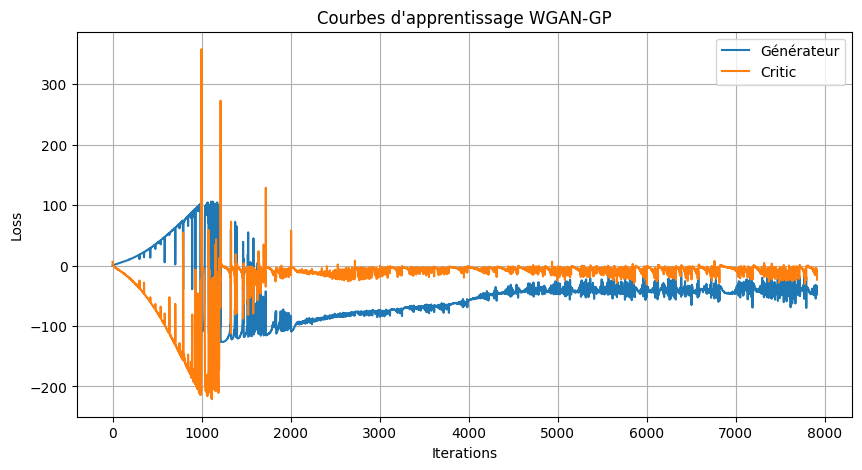

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(G_losses, label="Générateur")
plt.plot(D_losses, label="Critic")
plt.title("Courbes d'apprentissage WGAN-GP")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.savefig("learning_curves.png")
plt.show()


## 1. Explorations de l’espace latent

 Interpolation linéaire (latent walk)
Prendre deux vecteurs z₁, z₂ et tu fais :

```
alphas = torch.linspace(0, 1, steps=10)
z_interp = [(1 - a) * z1 + a * z2 for a in alphas]
```

Génèrer des images pour chaque z, et obtenir une transition fluide entre deux visages.

✅ Ça montre si l’espace latent est continu et cohérent.

Objectif : Générer une transition fluide entre deux visages  G(z1)→G(z2)
🧪 Étapes incluses :
- Chargement du modèle .pkl

- Création de deux vecteurs z₁, z₂

- Interpolation entre eux (linspace)

- Génération des visages

- Visualisation sous forme de grille

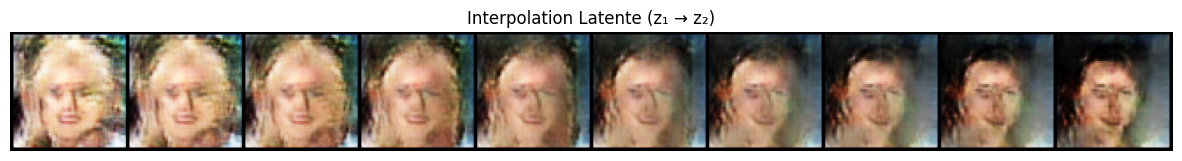

In [ ]:
# Imports
import torch
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import pickle
import numpy as np
from IPython.display import Image, display
import os

# Hyperparams
nz = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 🧠 Générateur (même archi que ton WGAN-GP)
class Generator(torch.nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        ngf = 64
        nc = 3
        self.main = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            torch.nn.BatchNorm2d(ngf * 8),
            torch.nn.ReLU(True),
            torch.nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            torch.nn.BatchNorm2d(ngf * 4),
            torch.nn.ReLU(True),
            torch.nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            torch.nn.BatchNorm2d(ngf * 2),
            torch.nn.ReLU(True),
            torch.nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            torch.nn.BatchNorm2d(ngf),
            torch.nn.ReLU(True),
            torch.nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            torch.nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

# 📂 Charger le modèle entraîné
netG = Generator().to(device)
with open("/content/generator.pkl", "rb") as f:
    netG.load_state_dict(pickle.load(f))
netG.eval()

# 🎯 Interpolation latente
def interpolate(z1, z2, steps=10):
    # Reshape to [steps, batch_size, nz, 1, 1]
    alpha = torch.linspace(0, 1, steps=steps, device=device)[:, None, None, None, None] # Create alpha values and reshape

    # Interpolate and reshape back to [steps, nz, 1, 1] for generator input
    z_interp = (1 - alpha) * z1[None, ...] + alpha * z2[None, ...]
    return z_interp.reshape(steps, nz, 1, 1)

# 🧪 Génération
z1 = torch.randn(1, nz, 1, 1, device=device)
z2 = torch.randn(1, nz, 1, 1, device=device)

z_interp = interpolate(z1, z2, steps=10).to(device)
with torch.no_grad():
    generated = netG(z_interp).cpu()

# 🖼️ Affichage
grid = vutils.make_grid(generated, nrow=10, normalize=True)
plt.figure(figsize=(15, 3))
plt.title("Interpolation Latente (z₁ → z₂)")
plt.axis("off")
plt.imshow(np.transpose(grid.numpy(), (1, 2, 0)))
plt.savefig("interpolation.png")
plt.show()

✅ Résultat attendu :

Une ligne d’images représentant une métamorphose douce d’un visage à un autre.
Chaque image correspond à :

𝑧(𝛼)=(1−𝛼)𝑧1+𝛼𝑧2   
avec 𝛼∈[0,1]


🌌 **T-SNE / UMAP de l’espace latent**

Génèrer N vecteurs z, tu les envoies dans G(z) → extrais les features (style/CLIP/face net) → projette :

```
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

latent_vectors = [z1, z2, ..., zN]  # shape (N, 100)
z_proj = TSNE(n_components=2).fit_transform(latent_vectors)
```

✅ À visualiser pour voir si les visages similaires sont regroupés.



🧠 Intuition :

Tu samples un grand nombre de z latents → tu génères les visages G(z)
→ tu projettes les z avec T-SNE/UMAP en 2D
→ tu visualises chaque point avec sa mini-image générée

✅ Étapes :

- Génère 500–1000 vecteurs z

- Passe-les dans G(z)

- Applique T-SNE ou UMAP sur les z

- Affiche les visages à leur coordonnée projetée

In [ ]:
import torch
import torchvision.utils as vutils
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
from PIL import Image
import pickle
import os

# 📍 Hyperparams
nz = 100
num_samples = 500
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 📦 Générateur
class Generator(torch.nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        ngf = 64
        nc = 3
        self.main = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            torch.nn.BatchNorm2d(ngf * 8),
            torch.nn.ReLU(True),
            torch.nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            torch.nn.BatchNorm2d(ngf * 4),
            torch.nn.ReLU(True),
            torch.nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            torch.nn.BatchNorm2d(ngf * 2),
            torch.nn.ReLU(True),
            torch.nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            torch.nn.BatchNorm2d(ngf),
            torch.nn.ReLU(True),
            torch.nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            torch.nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

# 🚀 Load Generator
netG = Generator().to(device)
with open("/content/generator.pkl", "rb") as f:
    netG.load_state_dict(pickle.load(f))
netG.eval()

#  1. Générer les vecteurs z
z_list = torch.randn(num_samples, nz, 1, 1).to(device)

#  2. Générer les images
with torch.no_grad():
    generated = netG(z_list).cpu()

#  3. T-SNE sur les vecteurs z
z_flat = z_list.view(num_samples, nz).cpu().numpy()
tsne_coords = TSNE(n_components=2, perplexity=30, learning_rate=200).fit_transform(z_flat)

# 🖼️ 4. Créer une visualisation avec mini-images
def plot_faces_2d(points, images, img_size=64, canvas_size=2000):
    canvas = Image.new('RGB', (canvas_size, canvas_size), 'white')
    norm_coords = (points - points.min(0)) / (points.max(0) - points.min(0) + 1e-8)

    for idx, coord in enumerate(norm_coords):
        x = int(coord[0] * (canvas_size - img_size))
        y = int(coord[1] * (canvas_size - img_size))
        face = transforms.ToPILImage()(images[idx])
        face = face.resize((img_size, img_size), Image.BILINEAR)
        canvas.paste(face, (x, y))
    return canvas

# 💡 5. Affichage
img_map = plot_faces_2d(tsne_coords, generated, img_size=48, canvas_size=2000)
img_map.save("latent_tsne_map.png")
img_map.show()


**Résultat attendu**

Une image avec des visages éparpillés comme une constellation.
Ce qu'on obtient :

* Des zones homogènes (styles proches)

* Des transitions douces ou abruptes (clusters ?)

🔁 **Variante : UMAP**

Remplace la partie T-SNE par :
```
from umap import UMAP
tsne_coords = UMAP(n_components=2).fit_transform(z_flat)
```

### **Métriques pour évaluer les visages générés**

🧠 **(a) FID – Fréchet Inception Distance**

Comparaison statistique entre les features (Inception-v3) des vrais visages et ceux générés.

```
pip install pytorch-fid
!python -m pytorch_fid path_to_real path_to_fake
```
Plus bas = mieux

< 10 → excellent

50 → pas réaliste


🧠 (b) Inception Score (IS)
Mesure la diversité + confiance du classifieur :

```
# Exemple avec torchvision.models.inception_v3
Score élevé → diversité + clarté
```


🧠 (c) CLIP Similarity (cosine)
Tu compares CLIP(G(z)) vs CLIP(real_face) :

```
import torch
import clip
from PIL import Image

model, preprocess = clip.load("ViT-B/32", device=device)
with torch.no_grad():
    img_features = model.encode_image(preprocess(fake_img).unsqueeze(0).to(device))
    ref_features = model.encode_image(preprocess(real_img).unsqueeze(0).to(device))
    sim = torch.nn.functional.cosine_similarity(img_features, ref_features)
  
```
✅ Donne un score de ressemblance sémantique

🎯 Objectif : Évaluer la qualité et la diversité des images générées.

* Est-ce que les visages sont réalistes ?

* Est-ce qu’il y a de la variété ?

* Est-ce que le modèle distingue bien les individus ?

###Étape 1 — FID Score (Fréchet Inception Distance)

In [ ]:
pip install pytorch-fid

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 132.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 107.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 43.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 110.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvji

In [ ]:
os.makedirs("fake", exist_ok=True)
with torch.no_grad():
    for i in range(1000):
        z = torch.randn(1, nz, 1, 1).to(device)
        fake = netG(z).cpu()
        vutils.save_image(fake, f"fake/{i:04d}.png", normalize=True)

Étape 2 — CLIP Similarity (visage vs texte ou visage cible)

In [ ]:
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 4.2 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-h_etm3a7
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-h_etm3a7
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369490 sha256=c754f0a41c32f48bf488b1149494e7ff8156307c95d3589e930cb8fd8af3a295
  Stored in directory: /tmp/pip-ephem-wheel-cache-eo48s_nx/wheels/3f/7c/a4/9b490845988bf7a4db33674d52f709f088f64392063872eb9a
Successfully built clip


In [ ]:
import clip
from PIL import Image

model, preprocess = clip.load("ViT-B/32", device=device)

image1 = preprocess(Image.open("fake/0001.png")).unsqueeze(0).to(device)
image2 = preprocess(Image.open("real/0001.jpg")).unsqueeze(0).to(device)

with torch.no_grad():
    f1 = model.encode_image(image1)
    f2 = model.encode_image(image2)

similarity = torch.nn.functional.cosine_similarity(f1, f2).item()
print(f"CLIP similarity: {similarity:.3f}")


100%|████████████████████████████████████████| 338M/338M [00:01<00:00, 196MiB/s]


FileNotFoundError: [Errno 2] No such file or directory: 'real/0001.jpg'

Image ↔ Texte

In [ ]:
text = clip.tokenize(["A face of a smiling woman"]).to(device)
with torch.no_grad():
    image_features = model.encode_image(image1)
    text_features = model.encode_text(text)
    score = torch.nn.functional.cosine_similarity(image_features, text_features).item()
print(f"Image ↔ 'smiling woman' : {score:.3f}")


Image ↔ 'smiling woman' : 0.260


**Étape 3 — Diversité (LPIPS ou Std)**
Peut servir de proxy si tu n’as pas LPIPS ou Inception

In [ ]:
z_samples = torch.randn(500, nz, 1, 1)
z_std = torch.std(z_samples.view(500, -1), dim=0).mean()
print(f"Std latent space: {z_std.item():.4f}")


Std latent space: 0.9960


Option **LPIPS** (Learned Perceptual Image Patch Similarity)

Pour mesurer la distance perceptuelle moyenne entre visages générés :

In [ ]:
!pip install lpips

import lpips
loss_fn = lpips.LPIPS(net='alex').to(device)

dists = []
for i in range(100):
    z1 = torch.randn(1, nz, 1, 1).to(device)
    z2 = torch.randn(1, nz, 1, 1).to(device)
    img1 = netG(z1)
    img2 = netG(z2)
    d = loss_fn(img1, img2)
    dists.append(d.item())

print(f"Moyenne LPIPS: {np.mean(dists):.4f}")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 4.7 MB/s eta 0:00:00
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 201MB/s]


Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth
Moyenne LPIPS: 0.2577
